<a href="https://colab.research.google.com/github/dgsmith1988/ECSE-552-Final-Project/blob/main/execution_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall Script Description
Run through each of the different cells to get things working. What should happen is that you connect to Google Drive, some data is transferred and then unzipped and then the model is trained on it and outputs data indicating correct operation. On the Google Drive there should also be files added under "Measurements" which have a date and time-stamp corresponding to the output of training process. The time stamps are generated by the Google Colab instance so they won't match exactly with your local time depending on where the instance they supplied us is located.

The cells are broken up based on functionality to make it easier to debug/profile/troubleshoot any issues which might come up.

In [1]:
# Autoreload : automatically reload imported scripts so that changes on them take effect.
%load_ext autoreload
%autoreload 2

# Initial configurations

In [2]:
# Install required libraries. 
# NOTE: if an error is thrown, then please restart Runtime and run again!
!pip install torchmetrics
!pip install pytorch-lightning
!pip install librosa
!pip install lightning-bolts
!pip install optuna

     |████████████████████████████████| 398 kB 4.9 MB/s 
     |████████████████████████████████| 582 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 136 kB 78.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 271 kB 72.7 MB/s 
     |████████████████████████████████| 144 kB 91.0 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 

# Configure Directories/Paths/Languages
The following cell is where you configure which languages you want to work with (from the three which are available on Google Drive at the moment). It is also where you set the paths to where the Google Drive will be mounted and where the data is extracted to.


In [3]:
import os
languages = ["EN", "DE", "ES"]
mount_point = '/content/drive'
load_path = os.path.join(mount_point, 'MyDrive/ECSE-552-FP/Data/')
unzip_path = '/content/speech_data'
save_path = '/MyDrive/ECSE-552-FP/Measurements'

from google.colab import drive
drive.mount(mount_point,force_remount= True)

Mounted at /content/drive


# Download and extract the dataset zip files
The following downloads and extracts the language zip files from Google Drive. It is done separately in it's own cell to make it easier to profile/debug things if there are issues in the network connection between Google Drive and Google Colab. 

This is separate from dataset creation for two reasons. The first is that if the network accesses are obscured by accessing the data via the network drive, it is much harder to debug bottlenecks in creating the dataset. The second is that all of the data must be transferred once at somepoint during one epoch, so it's easier to do it all up front and make sure the data is on the Colab instance before training. Localizing as much as possible to the Colab instance during training makes things easier to debug as well as more efficient.

There is a commented out code which allows you to select between the "debug" dataset and the "full" dataset for the languages. The "debug" set consists of a smaller subset (20 samples for each language) to aid in debugging the dataflow in models. It alleviates the need to run through the entire dataset and helps ensure all the pipes are connected correctly.

In [4]:
for language in languages:
    language_dir_path = os.path.join(unzip_path, language)
    os.makedirs(language_dir_path, exist_ok=True)
    # archive = language + "_debug_set" + ".zip"
    archive = language + ".zip"
    !unzip {os.path.join(load_path, archive)} -d {language_dir_path}

Streaming output truncated to the last 5000 lines.
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0022.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0023.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0024.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0025.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0026.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0027.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-fpq/wav/es-0028.wav  
   creating: /content/speech_data/ES/Dpkos-20090918-iqx/
   creating: /content/speech_data/ES/Dpkos-20090918-iqx/wav/
  inflating: /content/speech_data/ES/Dpkos-20090918-iqx/wav/es-0001.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-iqx/wav/es-0002.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-iqx/wav/es-0003.wav  
  inflating: /content/speech_data/ES/Dpkos-20090918-iqx/wav/es-0004.wav  
  inflating: /con

# Download the source code from GitHub

In [5]:
user = "dgsmith1988"
repo = "ECSE-552-Final-Project"
branch = "feat/prototypical"
src_dir = "Code"
pyfiles = ["models.py", "train.py", "dict_logger.py", "feature_extraction.py", "constants.py", "util.py"]

for pyfile in pyfiles:
    !rm {pyfile}
    url = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/{src_dir}/{pyfile}"
    !wget {url}


rm: cannot remove 'models.py': No such file or directory
--2022-04-05 01:02:22--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/feat/prototypical/Code/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7564 (7.4K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   7.39K  --.-KB/s    in 0s      

2022-04-05 01:02:22 (90.1 MB/s) - ‘models.py’ saved [7564/7564]

rm: cannot remove 'train.py': No such file or directory
--2022-04-05 01:02:23--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/feat/prototypical/Code/train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.c

In this section, we explore which set of hyperparameters gives the highest accuracy for the baseline model. The set of hyperparameters to analyse are :

- max_t : time to which all clips are to be cropped (seconds)
- bartch_size
- type of optimizer (Adam or SGD)

# Run/Train the Model
This is broken into tree parts:


1.   **Dataset:** select your dataset parameters and create it here
2.   **Model generation:** select and create your model here
3.   **Training the model:** select your training parameters and train the model here

This was done as there can be substantial overhead in generating the dataset and often only needs to be done once. The separation makes it easier to test different training loop parameters iteratively. 

The functions here are just suggestions and if there is a better way to create the datasets or you find it easier to implement these functions in Colab while developing then by all means go ahead and do that. There are various sub-functions which you can call (i.e. *split_dataset()* or *init_dataset()*) which handle fairly common things and can be used outside the *get_datatsets()* function. For instance if you want to change the amount of data being used without modifying the file system organization (as copying data will cost time) you could *init_dataset()* to load the files in and then resize it and then call *split_dataset()* to get the appropriate train/validation split. Re-organization of the code can easily happen after things have been proven out.

Note: Model and dataset generation could easily be split apart if need be



In [6]:
# Workaround for SSL verification problems. 
# https://github.com/Cadene/pretrained-models.pytorch/issues/193#issuecomment-644770084
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


from train import get_datasets

data_dir = "./speech_data"

train_dataset, val_dataset = get_datasets(
    data_dir=data_dir, dur_seconds=5, train_split=.8, crop=None,
    rgb_expand=False
)

Creating dataset


1601it [02:23, 11.17it/s]
1601it [01:49, 14.61it/s]
1601it [02:05, 12.72it/s]



Dataset creation in seconds:  378.79491928900006


Label: 0


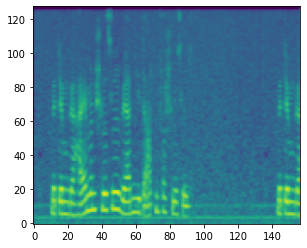

In [7]:
# Plot an example spectrogram.

import matplotlib.pyplot as plt

idx = 0

plt.imshow(train_dataset[idx][0], origin='lower')
print(f"Label: {train_dataset[idx][1]}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Creating measurements path...
Running on Colab
Initializing trainer...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | train_accuracy | Accuracy | 0     
2 | test_accuracy  | Accuracy | 0     
3 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

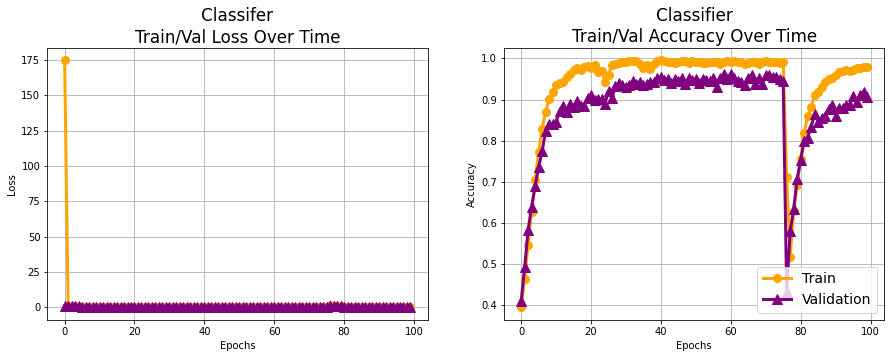

In [8]:
from constants import PROTOTYPICAL_NAME
from models import PrototypicalResnetClassifier
from train import train_model

model_name = PROTOTYPICAL_NAME

num_support = 5
num_classes = 3

model = PrototypicalResnetClassifier(num_classes=3, num_support=2)

train_model(model, model_name, train_dataset, val_dataset, max_epoch=100, 
    batch_size=128, do_early_stopping=False)

# Save model to Google Drive

In [9]:
# When a model needs to be saved for future analysis, it must be moved to Google drive, since colab is not-persistent

In [10]:
# First, download the move_checkpoint.py script
user = "dgsmith1988"
repo = "ECSE-552-Final-Project"
src_dir = "Code"
pyfiles = ["move_checkpoint.py"]

for pyfile in pyfiles:
    !rm {pyfile}
    url = f"https://raw.githubusercontent.com/{user}/{repo}/rubert/{src_dir}/{pyfile}"
    !wget {url}

rm: cannot remove 'move_checkpoint.py': No such file or directory
--2022-04-05 02:32:31--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/rubert/Code/move_checkpoint.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2255 (2.2K) [text/plain]
Saving to: ‘move_checkpoint.py’

move_checkpoint.py  100%[===================>]   2.20K  --.-KB/s    in 0s      

2022-04-05 02:32:32 (58.1 MB/s) - ‘move_checkpoint.py’ saved [2255/2255]



In [11]:
# NExt, move the desired file, and assigne a new meanigful_name. 
# it will be properly stored in the folder Checkpoints
from move_checkpoint import move_checkpoint
move_checkpoint(r'/content/DictLogger/0.1/checkpoints/epoch=4-step=10989.ckpt', 'first_step')

TypeError: ignored

In [ ]:
# TODO: which hyperparameters parmeters should be stored?
# TODO: do the checkpoints contain the required hyperparameters of a particular model? If not, is there a way to save these hyperparameters?
# TODO: what are the best ways to find the optimal parameters? Cross validation?
# TODO: should I include other metrics beyond loss?

In [ ]:
max_epoch = 5
# max_epoch = 20
batch_size = 10

train_model(model, model_name, train_dataset, val_dataset, max_epoch, batch_size)